## ResNet Model for classification of Diabetes and Normal categories

For this notebook pretrained Resnet50 model will be used to do a binary classification and predict between Normal and Diabetes categories.

### 00. Load libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 01. Load images
The images are separated into train, test and validation using the function of keras call image_dataset_from_directory

In [ ]:
train_dir = './N_D_labeled-images/train'
test_dir = './N_D_labeled-images/test'

BATCH_SIZE = 32
IMG_HEIGHT = 264
IMG_WIDTH = 264
EPOCHS = 100

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
# Creating generators (prepare data to feed the model)
training_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='training',
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='validation',
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=432,
)

Found 4032 files belonging to 2 classes.
Using 3226 files for training.
Found 4032 files belonging to 2 classes.
Using 806 files for validation.
Found 449 files belonging to 2 classes.


### 02. Model architecture

Loading of pretrained ResNet50 model with imagenet and creation of the architecture.

In [ ]:
pretrained = ResNet50(weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))

model.add(pretrained)

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 264, 264, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 165888)            0         
                                                                 
 dense (Dense)               (None, 256)               42467584  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
 activation (Activation)     (None, 1)                 0

### 03. Weight adjustment
As observed in the EDA, the classes were not balanced. In order for the model not to over-train, higher weights are given to those classes with fewer samples.

In [ ]:
cat_list = os.listdir('./N_D_labeled-images/train/')
cat_list.sort()

lenghts = [len(os.listdir('./N_D_labeled-images/train/'+cat)) for cat in cat_list]
total_train_images = np.sum(lenghts)

weights = list(np.sqrt(np.round(1/(np.array(lenghts) / total_train_images),2)))

print(cat_list)
print(lenghts)
print(weights)

['D', 'N']
[1447, 2585]
[1.6703293088490065, 1.2489995996796797]


### 04. Model train
We add earlystopping in order to keep the best model. If the model gets worse with increasing iterations, we will keep the best one.

For the learning_rate, a small value (0.001) is set so that the different combinations of parameters can be correctly explored until the optimum is reached.

The number of epochs was set at 100 in order to appreciate the evolution of the model during training.

In [ ]:
patience = 20

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [ ]:
# freeze resnet
pretrained.trainable = False

model.compile(loss='binary_crossentropy', loss_weights=weights,
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# Training
history = model.fit(
    training_generator,
    steps_per_epoch=1,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=1,
    verbose=1,
    callbacks = [early_stopping])

Epoch 1/100
1/1 [==============================] - 108s 108s/step - loss: 1.1931 - accuracy: 0.5625 - val_loss: 70.7289 - val_accuracy: 0.3750
Epoch 2/100
1/1 [==============================] - 18s 18s/step - loss: 74.0959 - accuracy: 0.3438 - val_loss: 2.4467 - val_accuracy: 0.8438
Epoch 3/100
1/1 [==============================] - 17s 17s/step - loss: 4.7632 - accuracy: 0.6875 - val_loss: 6.3758 - val_accuracy: 0.6875
Epoch 4/100
1/1 [==============================] - 17s 17s/step - loss: 7.6961 - accuracy: 0.6250 - val_loss: 9.5110 - val_accuracy: 0.3125
Epoch 5/100
1/1 [==============================] - 15s 15s/step - loss: 8.2213 - accuracy: 0.4062 - val_loss: 1.3467 - val_accuracy: 0.8125
Epoch 6/100
1/1 [==============================] - 16s 16s/step - loss: 3.6727 - accuracy: 0.4688 - val_loss: 2.9178 - val_accuracy: 0.2500
Epoch 7/100
1/1 [==============================] - 15s 15s/step - loss: 2.2921 - accuracy: 0.4375 - val_loss: 1.6388 - val_accuracy: 0.7188
Epoch 8/100
1/1 

In [ ]:
model.save('resnet50_binary-100epoch-freeze.h5')

### 05. Analysis of results

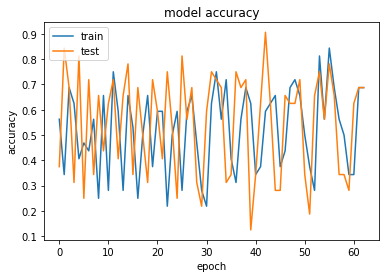

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It is observed that the accuracy does not vary throughout the training.
Although the accuracy takes values around 0.7, it is considered that it is not a good model since it is not improving throughout the learning process.

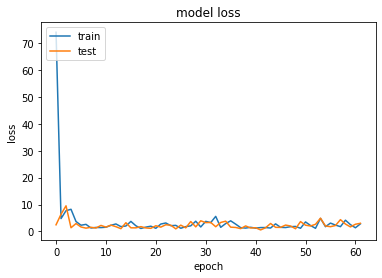

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In the case of loss, it is observed that as the epochs increase, their value decreases, which is the objective.

In [ ]:
model = load_model('resnet50_binary-100epoch-freeze.h5')

In [ ]:
## Predict on test data
y_pred = model.predict(test_generator)

In [ ]:
test_labels = []
for image_batch, labels_batch in test_generator:
  for vector in labels_batch:
    test_labels.append(vector.numpy().astype(int))

y_real = np.array(test_labels)

In [ ]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

Text(33.0, 0.5, 'Truth')

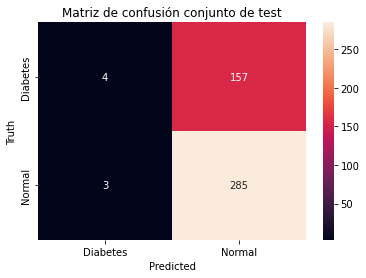

In [ ]:
cf_matrix = confusion_matrix(y_real, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='d')
plt.title('Matriz de confusión conjunto de test')
ax.xaxis.set_ticklabels(['Diabetes','Normal'])
ax.yaxis.set_ticklabels(['Diabetes','Normal'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

As can be seen in the confusion matrix, the model does not distinguish between the two classes and classifies most of the images as normal.

In [ ]:
print(classification_report(y_real, y_pred, target_names=['Diabetes','Normal']))

              precision    recall  f1-score   support

    Diabetes       0.57      0.02      0.05       161
      Normal       0.64      0.99      0.78       288

    accuracy                           0.64       449
   macro avg       0.61      0.51      0.41       449
weighted avg       0.62      0.64      0.52       449

